In [1]:
#!pip install statannotations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDown1e-10.py', '../models/SimplifierBottomUp.py', '../models/SimplifierTopDown1e-0.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierTopDown1e-6.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierTopDown1e-1.py'] ['Simplifier Top Down 1e-10', 'Simplifier Bottom Up', 'Simplifier Top Down 1e-0', 'Simplifier Top Down 1e-4', 'Simplifier Top Down 1e-6', 'Simplifier Top Down', 'Without simplification', 'Simplifier Top Down 1e-2', 'Simplifier Top Down 1e-1']
(1338, 14)
['Simplifier Top Down 1e-10' 'Simplifier Bottom Up'
 'Simplifier Top Down 1e-0' 'Simplifier Top Down 1e-4'
 'Simplifier Top Down 1e-6' 'Simplifier Top Down' 'Without simplification'
 'Simplifier Top Down 1e-2' 'Simplifier Top Down 1e-1']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing']
range(10, 250, 25)


In [2]:
from sympy import *
import re

func_dict = {
   'multiply': '*',
   'subtract': '-',
   'add3': '+',
   'add4': '+',
   'mul3': '*',
   'mul4': '*',
   'cdiv': '/',
   'add': '+'
}

func_arity = {
   'multiply': 2,
   'subtract': 2,
   'add3': 3,
   'add4': 4,
   'mul3': 3,
   'mul4': 4,
   'cdiv': 2,
   'add': 2,
    'maximum' : 2,
    'minimum' : 2,
    'max' : 2,
    'min' : 2,
    'sin' : 1,
    'cos' : 1,
    'tan' : 1,
    'sqrtabs' : 1,
    'sqrt' : 1,
    'abs' : 1,
    'log1p'   : 1,
    'exp'     : 1,
    'square'  : 1,
    'absolute'     : 1
}

def pretify_expr(string):
    # Breaking down into a list of symbols. handliilng sqrtabs and max/minimum
    ind = string.replace('sqrtabs','sqrt').replace('imum','') \
                .replace(' ','').replace(')','').replace('(',',').split(',')

    new_string = ""
    stack = []
    for node in ind:
        stack.append((node, []))
        while len(stack[-1][1]) == func_arity.get(stack[-1][0], 0):

            prim, args = stack.pop()
            new_string = prim
            if prim in func_dict.keys():
                new_string = '(' + func_dict[prim].join(args) + ')'
            elif not prim.startswith('x_'):
                try:
                    float(prim)
                except:
                    new_string = prim + '(' + args[0] + ')'
                
            if len(stack) == 0:
                break

            stack[-1][1].append(new_string)

    return new_string

def count_float_occurrences(s):
   pattern = r'\d+\.\d+' # Matches sequences of digits followed by a dot and more digits
   matches = re.findall(pattern, s)
   return len(matches)

def count_occurrences(s, sub):
   res = 0
   for i in range(len(s)):
       if s[i:i+len(sub)] == sub:
           res += 1
   return res

funcs = [
'-', '+', '+', '/', 'maximum', 'minimum', 'max', 'min', 'sin', 'cos', 'tan', 'sqrtabs', 
'sqrt', 'abs', 'log1p', 'exp', 'square', 'absolute']

In [3]:
new_columns = []

for i, col in results_df.iterrows():
    sympy_compatible = str(pretify_expr(col['representation']))
    sympy_simplified = str(simplify(sympy_compatible))

    # stats: number of functions, constants, variables, and total number ofnodes
    n_features_before  = count_occurrences(sympy_compatible, "x_")
    n_constants_before = count_float_occurrences(sympy_compatible)
    n_functions_before = sum([count_occurrences(sympy_compatible, f)
                              for f in funcs])

    n_features_after  = count_occurrences(sympy_simplified, "x_")
    n_constants_after = count_float_occurrences(sympy_simplified)
    n_functions_after = sum([count_occurrences(sympy_simplified, f)
                             for f in funcs])

    new_columns.append([
        n_features_before-n_features_after,
        n_constants_before-n_constants_after,
        n_functions_before-n_functions_after,
        (n_features_before+n_constants_before+n_functions_before)-\
        (n_features_after+n_constants_after+n_functions_after),
    ])

deltas_df = pd.DataFrame(new_columns, columns=['features simplified',
                                               'constants simplified',
                                               'functions simplified',
                                               'nodes simplified'])

results_df = pd.concat([results_df, deltas_df], axis=1 )
results_df.sample(3)

,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth,features simplified,constants simplified,functions simplified,nodes simplified
1140,Simplifier Top Down 1e-0,Housing,0,16695,802.911298,01-14-2024 20:21:52,0.654955,0.610931,21.063269,25.996904,"add4(x_3, x_5, multiply(x_5, cdiv(11.642074170113005, x_12)), cdiv(minimum(x_11, 147.86704760311366), x_10))",13,96,3,0,0,-1,-1
880,Simplifier Top Down 1e-0,Energy Heating,0,31658,714.743263,01-14-2024 19:54:19,0.921199,0.943118,7.707718,5.980062,"mul3(add(x_2, sqrtabs(mul3(log1p(x_6), -0.16966959385294672, mul4(-33.80205918710473, x_4, x_2, -14.823722428261442)))), x_4, 0.008656329815529848)",15,18462,5,0,-2,-2,-4
728,Without simplification,Energy Cooling,0,27690,1007.718625,01-14-2024 02:37:02,0.909574,0.921253,7.405172,6.646680,"mul3(0.7772219528473163, x_4, add3(x_4, cdiv(add3(multiply(sin(x_6), 98.68118747034352), -10.666815336959917, x_3), 27.45456386926229), cdiv(-7.450290002826636, sin(x_1))))",18,1218,6,0,1,-5,-4


[[<Axes: ylabel='features simplified'>]]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



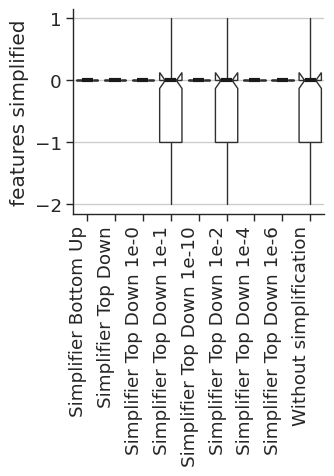

[[<Axes: ylabel='constants simplified'>]]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



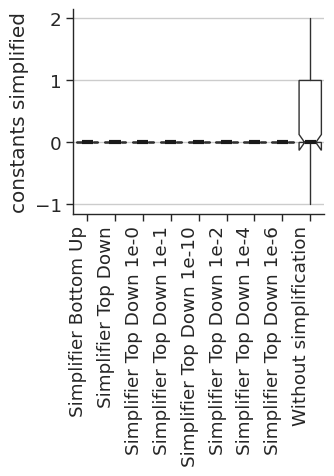

[[<Axes: ylabel='functions simplified'>]]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Simplifier Top Down 1e-6 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.555e-04 U_stat=1.405e+04
Simplifier Top Down 1e-4 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.214e-05 U_stat=1.425e+04
Simplifier Top Down 1e-2 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.922e-06 U_stat=1.464e+04
Simplifier Top Down 1e-10 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.061e-03 U_stat=1.242e+04
Simplifier Top Down 1e-1 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.640e-07 U_

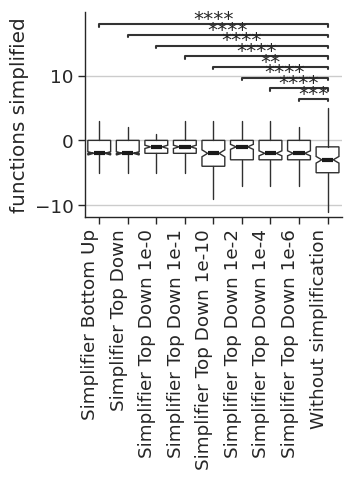

[[<Axes: ylabel='nodes simplified'>]]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Simplifier Top Down 1e-6 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.669e-02 U_stat=1.303e+04
Simplifier Top Down 1e-4 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.366e-04 U_stat=1.383e+04
Simplifier Top Down 1e-2 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.416e-03 U_stat=1.351e+04
Simplifier Top Down 1e-1 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.105e-04 U_stat=1.401e+04
Simplifier Top Down 1e-0 vs. Without simplification: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.052e-07 U_stat=

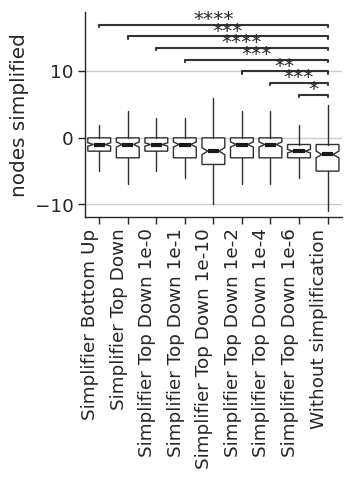

In [4]:
for yaxis in deltas_df.columns:
    g=sns.catplot( data=results_df, y=yaxis, x='model', 
        legend_out=False, aspect=0.75,
        order = order, # The first is Baseline
        **{**boxplot_kwargs, **{'showfliers':False}}, sharey=False
    )

    # g.set(yscale="log")
    g.set_titles("{col_name}").set_axis_labels("", yaxis)

    print(g.axes)

    # iterate through each subplot / Facet
    plot_ax = g.axes[0, 0]

    plot_ax.grid(which='major', axis='y', linewidth=1)

    for tick in plot_ax.get_xticklabels():
        tick.set(rotation=90, ha="right")

    if True:
        # All vs baseline
        pairs = [('Without simplification', l)
                    for l in results_df['model'].unique()
                    if l != 'Without simplification']

        annotator = Annotator(
            plot_ax, pairs, data=results_df,
            x='model', y=yaxis,
            order=order)
        annotator.reset_configuration()
        annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
        annotator.apply_and_annotate()

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.pdf")
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.png")
    plt.show()